# Time Series DataOps

## Part 1 - KDB.AI Cloud Temporal Similarity Search

### Purpose of this Notebook

**Question:**  

KDB.ai already has an on-boarding / quickstart and collection of Colab-ready samples on their excellent [learning-hub](https://kdb.ai/learning-hub/samples/quickstart-guide/), so what problem does this .ipynb solve?

**Answer:**

I originally made this .ipynb for my own personal use so I didn't need to keep track of my API KEY / Token. The benefit of being able to duplicate this version vs the original is that this notebook is "Part 1" in series dedicated to time-series DataOps / MLOps illustrating ways that different tools can be combined to form a complete Web Application or time series analytics dashboard.

For that reason, most of the code is lifted wholecloth from the following Github Repo / .ipynb:
https://colab.research.google.com/github/KxSystems/kdbai-samples/blob/main/TSS_non_transformed/Temporal_Similarity_Search_Non-Transformed_Demo.ipynb

That link should be considered the definitive reference with the KDB.ai [learning-hub](https://kdb.ai/learning-hub/samples/) and [github repo](https://github.com/KxSystems/kdbai-samples/) being a better resource for Kdb specific deep-dives.

## Follow these steps to connect to the database. (REST API)

You will need a Kdb.ai API Key "Token" and "Endpoint"

These can be found here: https://cloud.kdb.ai/

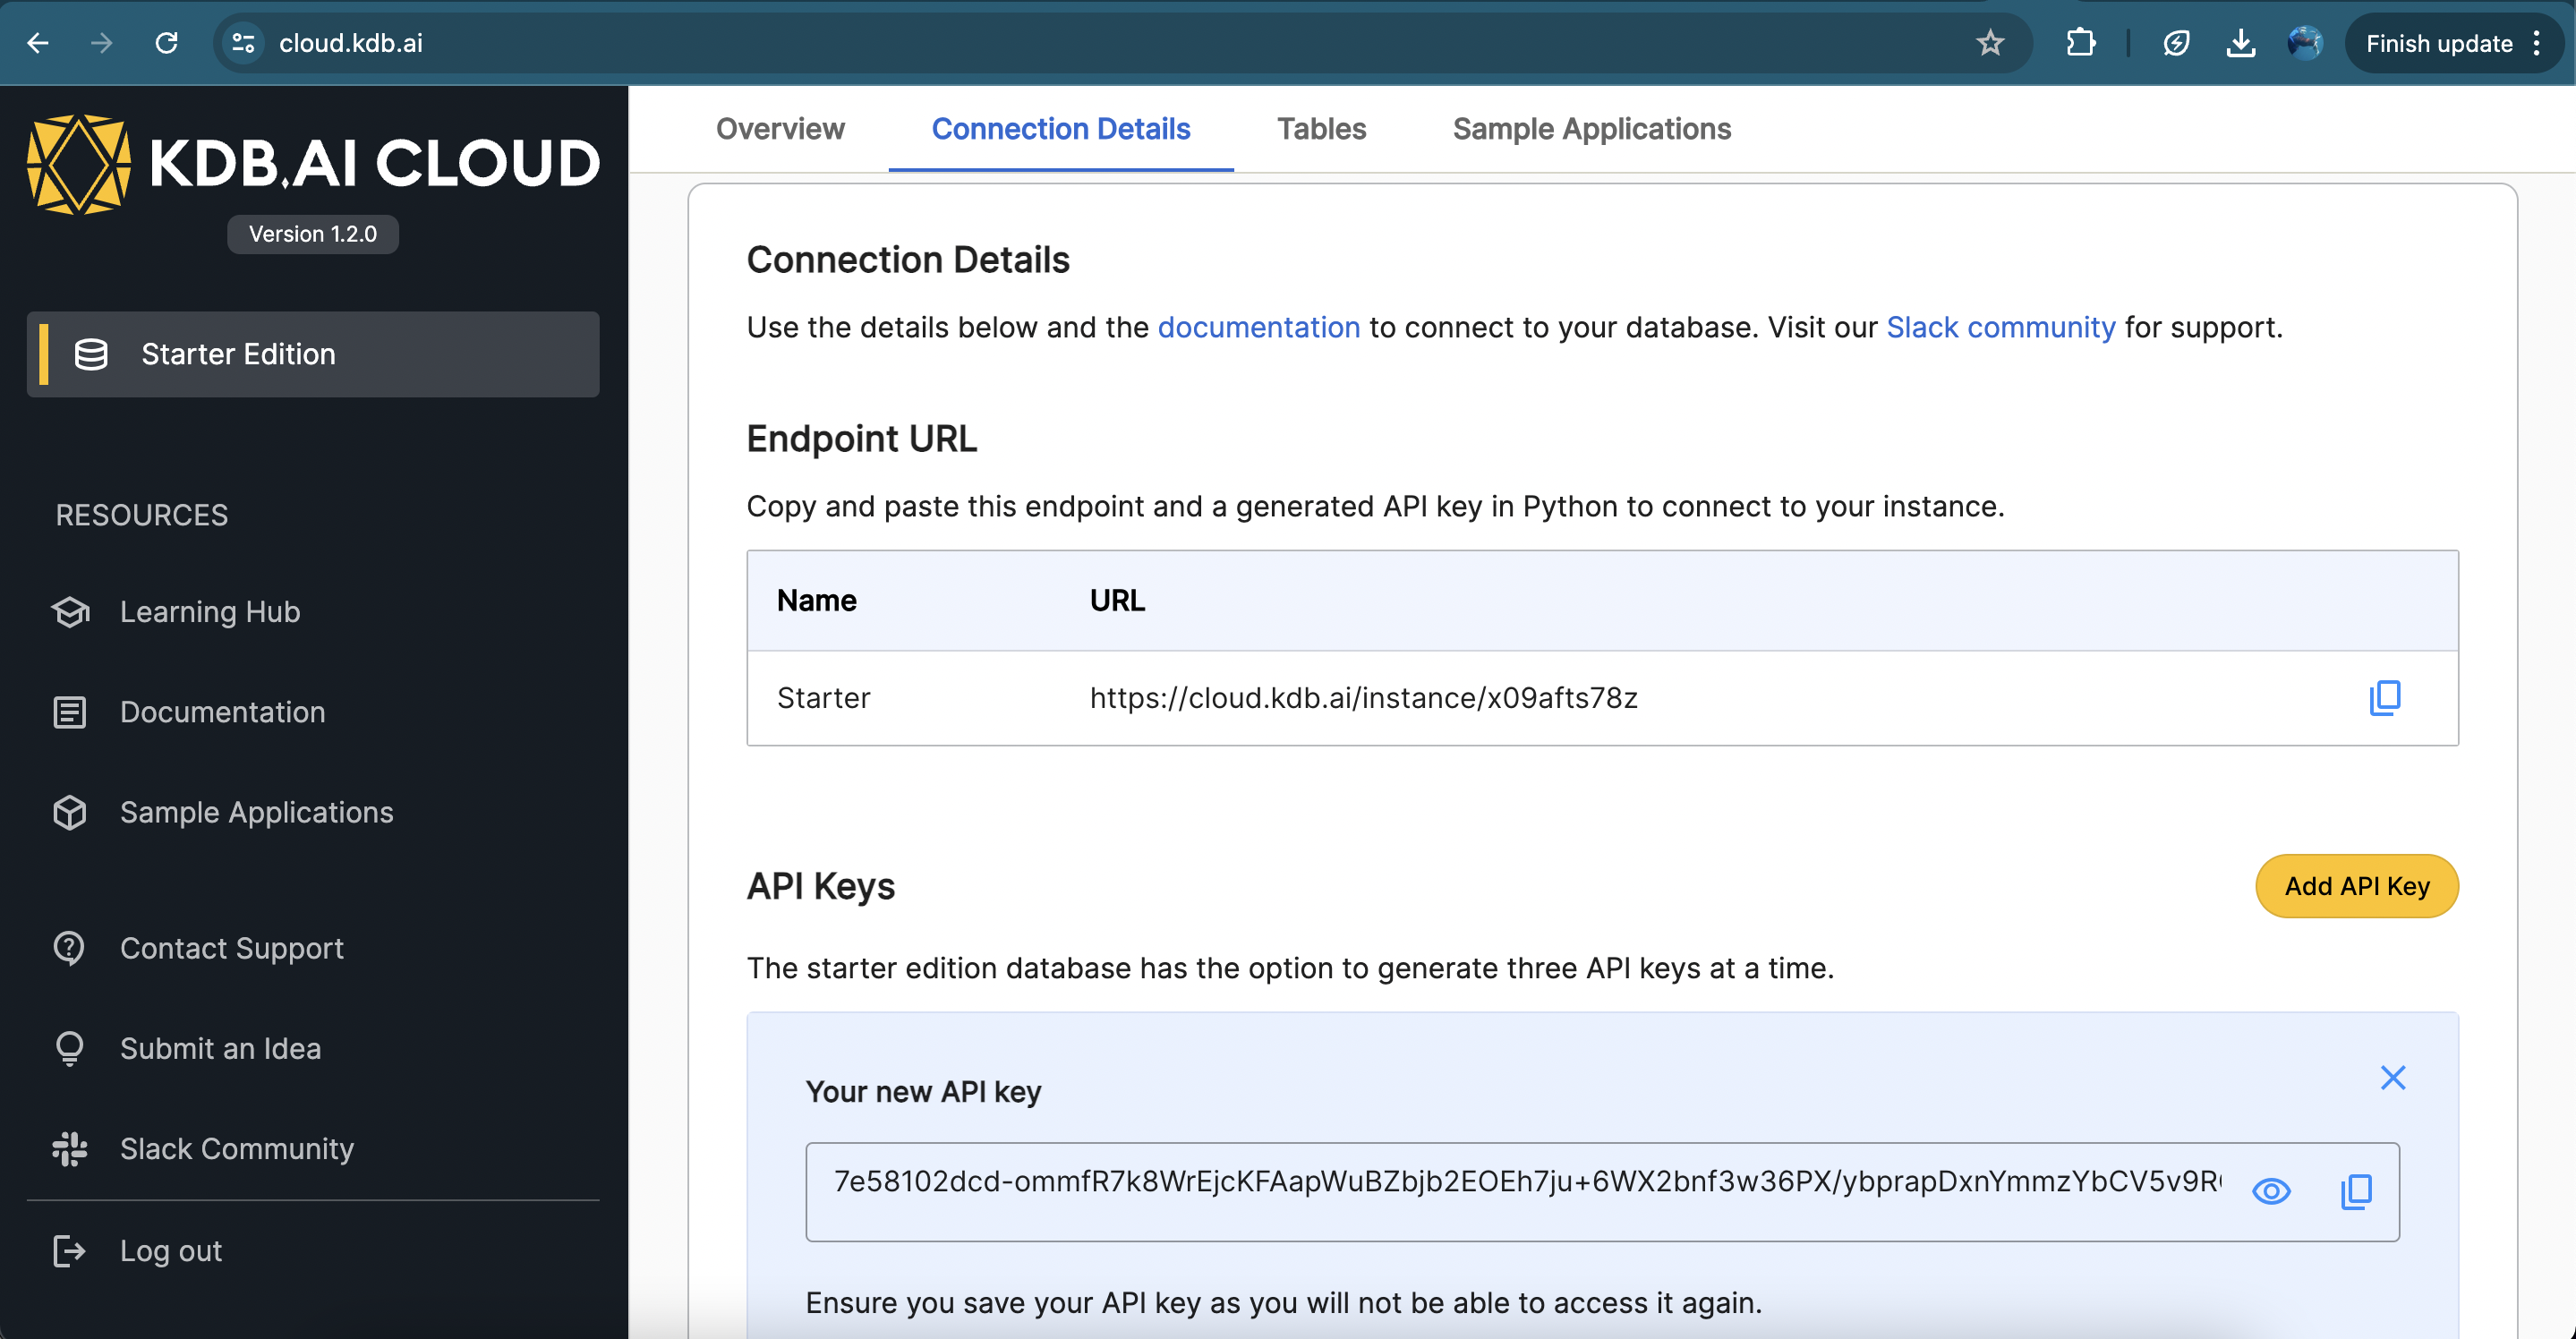

In [66]:
# Set API Token and Endpoint Environment variables

!export KDBAI_TOKEN="7e5810****************************************************"
!export KDBAI_ENDPOINT="https://cloud.kdb.ai/instance/x09afts78z"

In [ ]:
# Use Curl to validate the REST API is working

In [14]:
!curl -H "X-Api-Key: $KDBAI_TOKEN" $KDBAI_ENDPOINT/api/v1/ready

OK

## Follow these steps to connect to the database. (Python)

You will need a Kdb.ai API Key "Token" and "Endpoint"

These can be found here: https://cloud.kdb.ai/

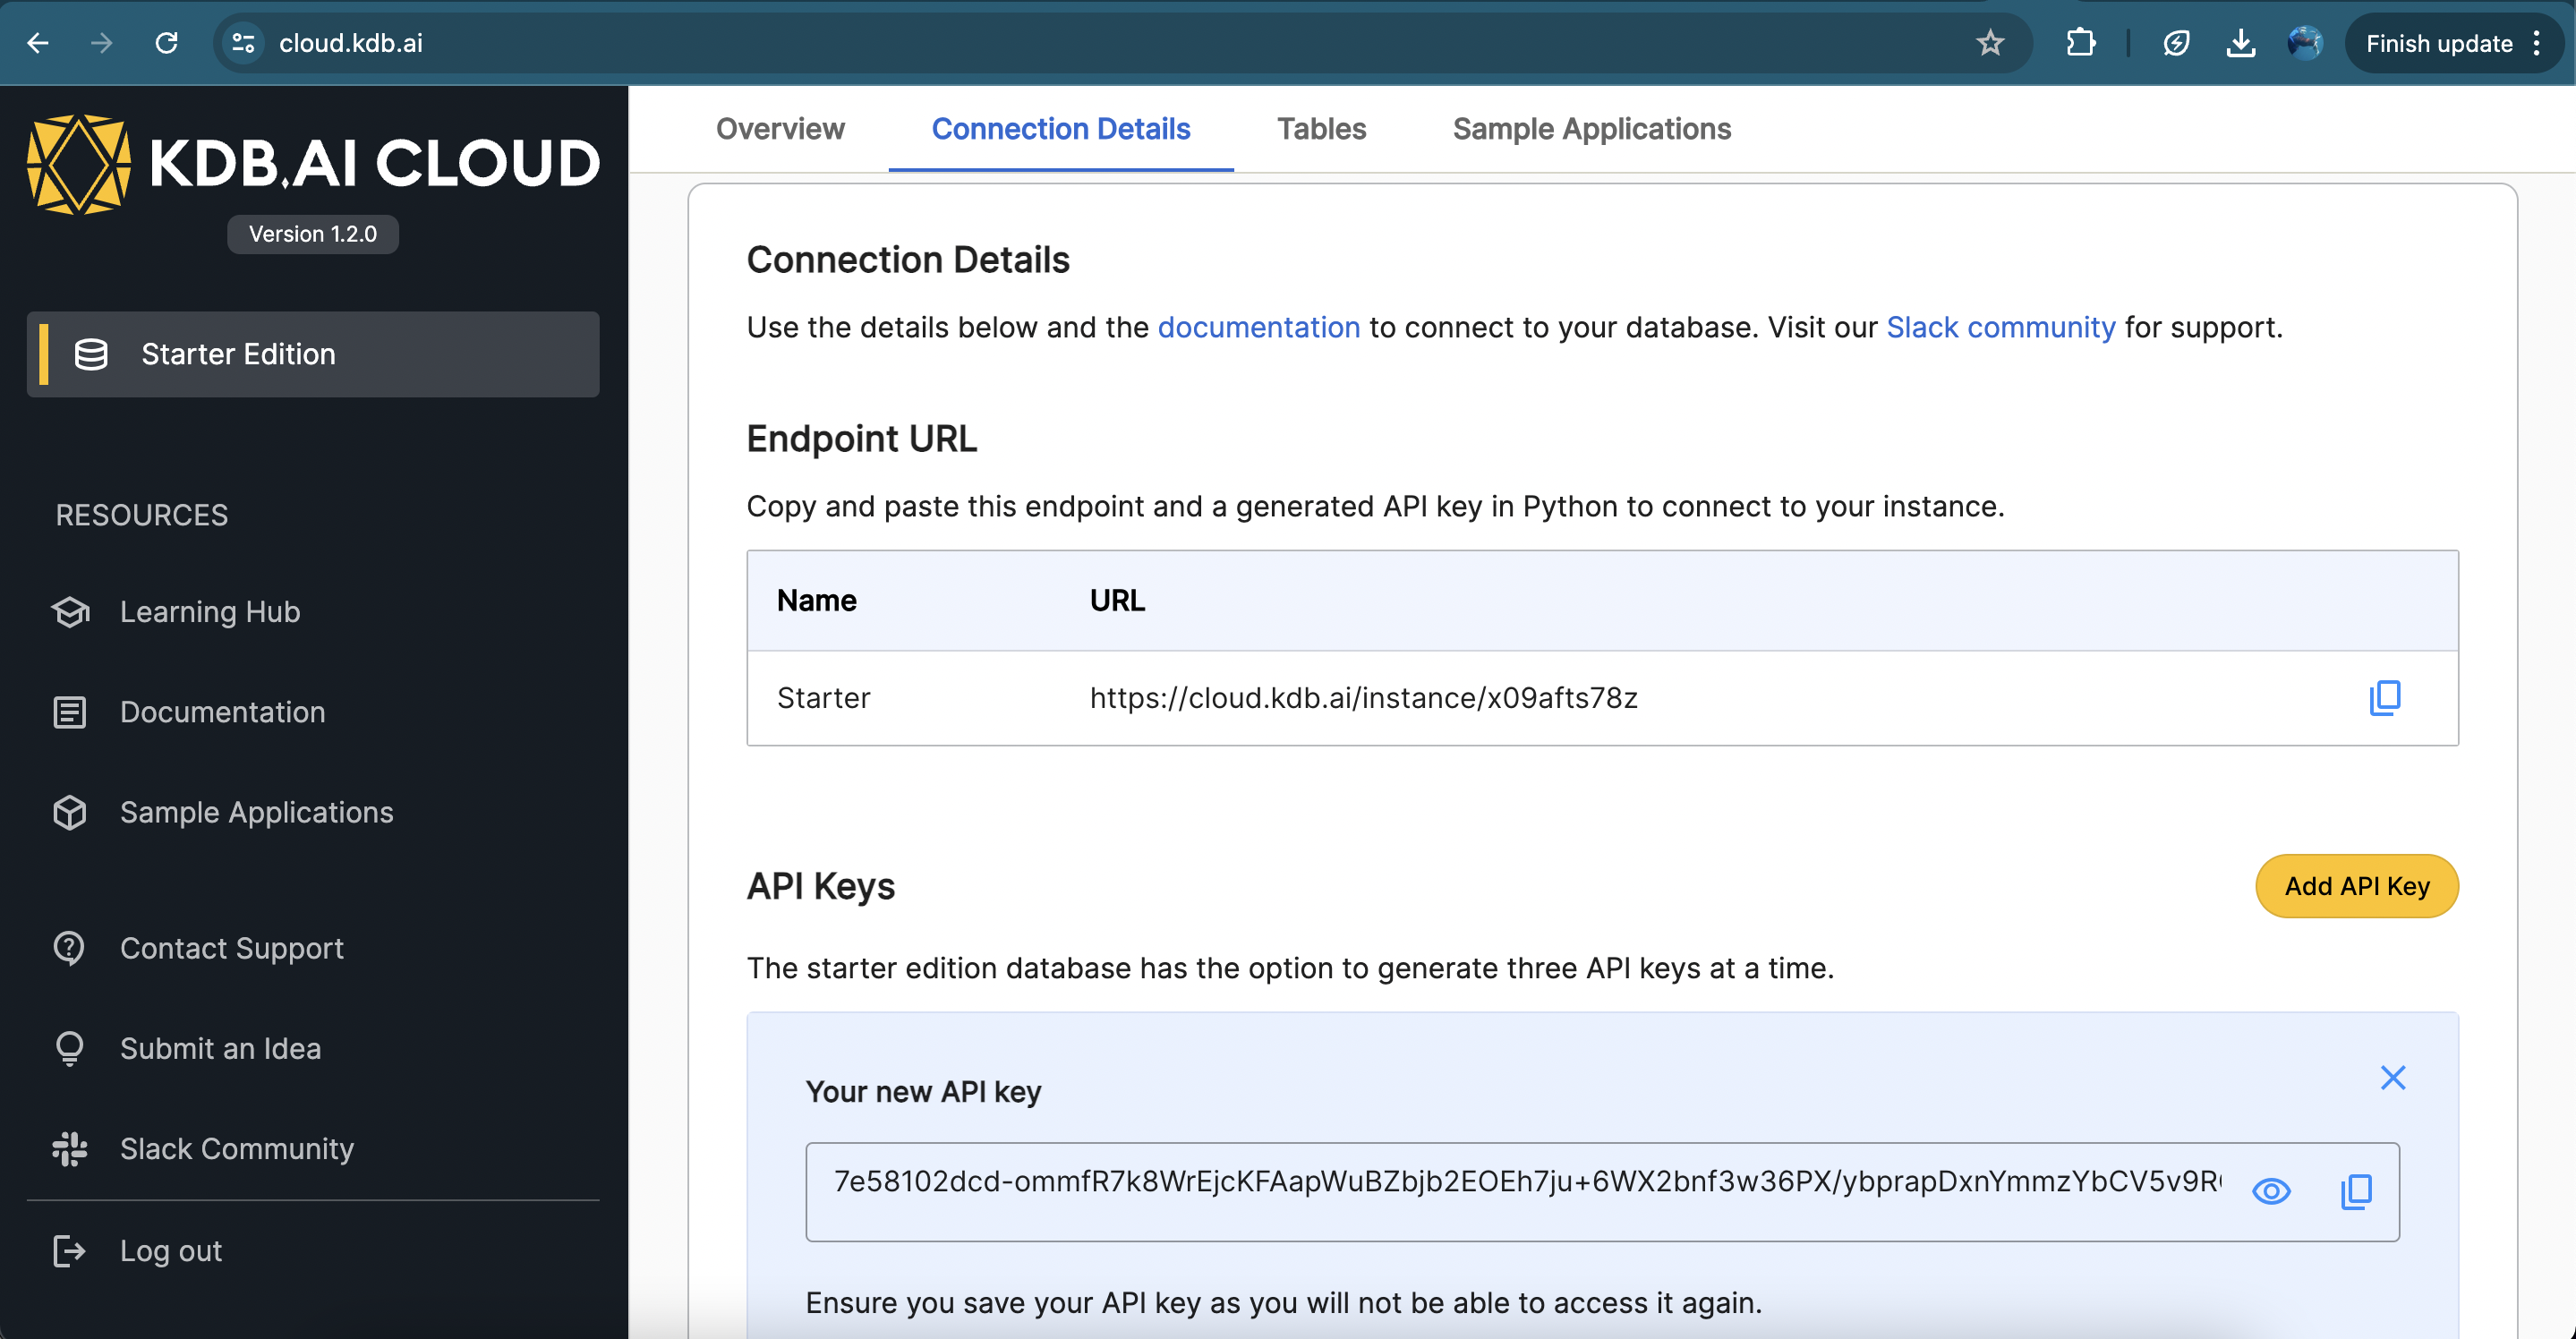

In [67]:
# Define API Token and Endpoint Python variables

KDBAI_TOKEN = "7e5810****************************************************"
KDBAI_ENDPOINT = "https://cloud.kdb.ai/instance/x09afts78z"

In [2]:
!pip install kdbai-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 15.1 MB/s eta 0:00:00


In [10]:
import kdbai_client as kdbai
session = kdbai.Session(endpoint=KDBAI_ENDPOINT, api_key=KDBAI_TOKEN)

# Financial Time Series Analysis Example

Credit: https://colab.research.google.com/github/KxSystems/kdbai-samples/blob/main/TSS_non_transformed/Temporal_Similarity_Search_Non-Transformed_Demo.ipynb

In [17]:
### !!! Only run this cell if you need to download the data into your environment, for example in Colab
### This downloads sample market data
!mkdir ./data
!wget -P ./data https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/TSS_non_transformed/data/marketTrades.parquet

--2024-07-07 09:54:51--  https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/TSS_non_transformed/data/marketTrades.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1277201 (1.2M) [application/octet-stream]
Saving to: ‘./data/marketTrades.parquet’

marketTrades.parque 100%[===================>]   1.22M  --.-KB/s    in 0.04s   

2024-07-07 09:54:51 (29.0 MB/s) - ‘./data/marketTrades.parquet’ saved [1277201/1277201]



In [19]:
# Import Dependencies
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from getpass import getpass
import time

In [22]:
# Dependencies for metric gathering
import psutil
import datetime

# Report memory usage of Python + KDB.AI
def get_memory_usage():
    virtual_memory = psutil.virtual_memory()
    return virtual_memory.used / (1024 ** 2)  # Memory usage in megabytes

In [20]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [21]:
df = pd.read_parquet('data/marketTrades.parquet')
df

,index,time,sym,qty,price
0,0,2024-02-19 00:00:23.408442735,AAA,8000,25.198061
1,1,2024-02-19 00:00:50.002746284,AAA,2000,25.589870
2,2,2024-02-19 00:01:13.951318860,AAA,4000,25.435139
3,3,2024-02-19 00:01:21.386703997,AAA,1000,25.378082
4,4,2024-02-19 00:01:48.257409185,AAA,8000,25.830731
...,...,...,...,...,...
49995,49995,2024-03-04 23:56:43.126595914,BBB,3000,17.611573
49996,49996,2024-03-04 23:56:49.295240789,BBB,3000,17.652760
49997,49997,2024-03-04 23:57:06.397743076,BBB,1000,17.215983
49998,49998,2024-03-04 23:59:19.743730723,BBB,10000,17.096576


## Create KDB.AI Schema & Table

In [23]:
# First ensure the table does not already exist
if 'trade_tss' in session.list():
    table = session.table('trade_tss')
    table.drop()

In [24]:
# Define the schema with similar columns to the dataframe. The price column is where the time series vectors will be inserted
# The vectorIndex type in the price column uses type 'tss', which represents Non-Transformed Temporal Similarity Search
schema = dict(
    columns=[
        dict(
            name='index',
            pytype='int64'
            ),
        dict(
            name='time',
            pytype='datetime64[ns]'
            ),
        dict(
            name='sym',
            pytype='str'
            ),
        dict(
            name='qty',
            pytype='int64'
            ),
        dict(
            name='price',
            pytype='float64',
            vectorIndex=
                dict(
                    type='tss',
                    metric='L2'
                    )
            )
        ]
    )

In [25]:
#Create the table called "trade_tss"
table = session.create_table('trade_tss', schema)

## Insert Data into KDB.AI Table

In [26]:
table.insert(df)

'Insert successful'

## Run Non-Transformed Temporal Similarity Search

This code creates a vector datataframe consisting of a 1000 period sliding window price sample per row / time / index.

In [41]:
# Create raw windows
D = 1000 # Sliding Window Size
vecdf = df.groupby(['sym']).apply(
    lambda x: pd.DataFrame({
        'time': sliding_window_view(x['time'], D)[:, 0],  # Adjusted to keep the last time in the window
        'sym': x['sym'].iloc[0],
        'price': list(sliding_window_view(x['price'], D))
    })
).reset_index(drop=True).reset_index()
memory_vecdf_created=get_memory_usage()

In [52]:
q = vecdf['price'][100].tolist()

In [53]:
vecdf.head()

,index,time,sym,price
0,0,2024-02-19 00:00:23.408442735,AAA,"[25.1980605549179, 25.58986971201375, 25.43513..."
1,1,2024-02-19 00:00:50.002746284,AAA,"[25.58986971201375, 25.43513912591152, 25.3780..."
2,2,2024-02-19 00:01:13.951318860,AAA,"[25.43513912591152, 25.37808242137544, 25.8307..."
3,3,2024-02-19 00:01:21.386703997,AAA,"[25.37808242137544, 25.830730823799968, 25.607..."
4,4,2024-02-19 00:01:48.257409185,AAA,"[25.830730823799968, 25.607446282170713, 26.07..."


Text(0.5, 1.0, 'Query Vector')

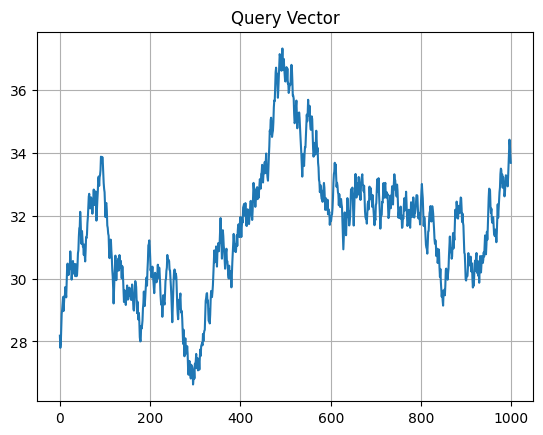

In [54]:
plt.plot(q) # See what the search vector looks like
plt.grid(True)
plt.title('Query Vector')

### Temporal Similarity Search
Run similarity search using our query vector q, and returning the top 10 most similar matches. We also collect some stats on the search for later analysis

In [55]:
sim_start=datetime.datetime.now()
res = table.search(vectors=[q], n=10)[0]
sim_stop=datetime.datetime.now()
memory_sim_post_search=get_memory_usage()
res

,index,time,sym,qty,price,tss_dist
0,95,2024-02-19 01:19:09.146237969,AAA,7000,29.201223,0.000013
1,96,2024-02-19 01:19:27.989527434,AAA,1000,28.989396,4.527070
2,97,2024-02-19 01:19:32.584855556,AAA,6000,28.734376,4.532988
3,98,2024-02-19 01:19:35.593288242,AAA,9000,28.493217,6.594388
4,99,2024-02-19 01:20:12.802501022,AAA,2000,27.996566,6.612245
5,100,2024-02-19 01:22:33.092023730,AAA,8000,28.180955,7.984468
6,101,2024-02-19 01:22:40.782989859,AAA,2000,27.793489,8.011267
7,102,2024-02-19 01:24:08.510938882,AAA,7000,27.933083,9.142472
8,103,2024-02-19 01:24:39.233463853,AAA,9000,28.403252,9.172721
9,104,2024-02-19 01:26:20.481255054,AAA,9000,28.880188,10.124061


The 95th vector, which is identical to the query vector 'q', was returned as the top result. We also see that the vectors surrounding the 100th vector are also returned, which is expected as they will also contain large segments similar to the query vector.

### Outlier Search
Another feature of Non-Transformed Temporal Similarity Search is the ability to do outlier search. This will return the most dissimilar vectors.

To do this, we run a search with n equal to the negative of the number of most dissimilar results we want returned, for example n = -10.

In [51]:
out_start=datetime.datetime.now()
res = table.search(vectors=[q], n=-10)[0]
out_stop=datetime.datetime.now()
memory_out_windows_post_search=get_memory_usage()
res

,index,time,sym,qty,price,tss_dist
0,13067,2024-02-26 20:28:37.438575625,AAA,4000,59.016131,59.155336
1,13068,2024-02-26 20:28:40.266260951,AAA,7000,58.614463,59.146700
2,13069,2024-02-26 20:29:20.973946005,AAA,2000,58.690888,59.136441
3,13070,2024-02-26 20:30:26.397550106,AAA,9000,58.770047,59.134685
4,13071,2024-02-26 20:32:00.419369638,AAA,4000,59.093172,59.120700
5,13072,2024-02-26 20:32:59.920857399,AAA,4000,58.847480,59.115242
6,13073,2024-02-26 20:33:17.896016389,AAA,5000,59.138623,59.098945
7,13074,2024-02-26 20:33:45.411256402,AAA,2000,59.351530,59.098050
8,13075,2024-02-26 20:34:19.050180763,AAA,4000,59.715426,59.086551
9,13076,2024-02-26 20:34:52.536420375,AAA,5000,59.826193,59.076016


### Dynamic Search
A strengh of Non-Transformed Temporal Similarity Search is the ability to change the size (number of data points) of the query vector between searches.
This means we do not need to create new embeddings to search over different window sizes.

See the [documentation](https://code.kx.com/kdbai/reference/non-transformed-tss.html) for more details.

In this example, our query vector is reduced to 50 data points from the original 1000 data point query vector:

In [60]:
smaller_query_50=q[:-950]
print("Query elements: ", len(smaller_query_50))
table.search(vectors=[smaller_query_50], n=10)[0]

Query elements:  50


,index,time,sym,qty,price,tss_dist
0,99,2024-02-19 01:20:12.802501022,AAA,2000,27.996566,0.000000
1,100,2024-02-19 01:22:33.092023730,AAA,8000,28.180955,2.060435
2,101,2024-02-19 01:22:40.782989859,AAA,2000,27.793489,2.140956
3,14905,2024-02-27 23:14:51.579989343,AAA,4000,59.699730,2.369705
4,14906,2024-02-27 23:17:01.033421158,AAA,9000,59.331964,2.375721
5,14907,2024-02-27 23:18:12.271115630,AAA,9000,58.904305,2.385418
6,19547,2024-03-01 16:56:43.881322592,AAA,8000,77.814046,2.388048
7,27249,2024-02-20 07:46:35.792305469,BBB,6000,15.817259,2.431020
8,27250,2024-02-20 07:48:04.330449253,BBB,9000,15.494382,2.434130
9,42517,2024-02-29 10:50:59.415277093,BBB,6000,10.757307,2.459691


Let's try another search with a 500 element query vector:

In [61]:
smaller_query_500=q[:-500]
print("Query elements: ", len(smaller_query_500))
table.search(vectors=[smaller_query_500], n=10)[0]

Query elements:  500


,index,time,sym,qty,price,tss_dist
0,96,2024-02-19 01:19:27.989527434,AAA,1000,28.989396,0.000000
1,97,2024-02-19 01:19:32.584855556,AAA,6000,28.734376,2.973744
2,98,2024-02-19 01:19:35.593288242,AAA,9000,28.493217,2.989074
3,99,2024-02-19 01:20:12.802501022,AAA,2000,27.996566,4.320273
4,100,2024-02-19 01:22:33.092023730,AAA,8000,28.180955,4.364905
5,101,2024-02-19 01:22:40.782989859,AAA,2000,27.793489,5.199802
6,102,2024-02-19 01:24:08.510938882,AAA,7000,27.933083,5.293356
7,103,2024-02-19 01:24:39.233463853,AAA,9000,28.403252,5.912937
8,104,2024-02-19 01:26:20.481255054,AAA,9000,28.880188,6.068448
9,105,2024-02-19 01:27:28.738277703,AAA,6000,29.004960,6.461498


### Multi Search
The power of Non-Transformed Temporal Similarity Search is shown with multi search, where we search over multiple window sizes simultaneously.

Here we search with each of the 1000, 500, and 50 data point query vectors:

As you will see, the time for running multiple searches is significantly less than expected.

In [62]:
multi_start=datetime.datetime.now()
results = table.search(vectors=[q, smaller_query_50, smaller_query_500], n=10)
multi_stop=datetime.datetime.now()
for result in results:
    print(result)
    print()

   index                          time  sym   qty      price   tss_dist
0     95 2024-02-19 01:19:09.146237969  AAA  7000  29.201223   0.000013
1     96 2024-02-19 01:19:27.989527434  AAA  1000  28.989396   4.527070
2     97 2024-02-19 01:19:32.584855556  AAA  6000  28.734376   4.532988
3     98 2024-02-19 01:19:35.593288242  AAA  9000  28.493217   6.594388
4     99 2024-02-19 01:20:12.802501022  AAA  2000  27.996566   6.612245
5    100 2024-02-19 01:22:33.092023730  AAA  8000  28.180955   7.984468
6    101 2024-02-19 01:22:40.782989859  AAA  2000  27.793489   8.011267
7    102 2024-02-19 01:24:08.510938882  AAA  7000  27.933083   9.142472
8    103 2024-02-19 01:24:39.233463853  AAA  9000  28.403252   9.172721
9    104 2024-02-19 01:26:20.481255054  AAA  9000  28.880188  10.124061

   index                          time  sym   qty      price  tss_dist
0     99 2024-02-19 01:20:12.802501022  AAA  2000  27.996566  0.000000
1    100 2024-02-19 01:22:33.092023730  AAA  8000  28.180955  2.0

## Search Evaluation

### Memory Usage

In [64]:
sim_used=memory_sim_post_search-memory_vecdf_created
print(f"Sim  (MB): {sim_used:.2f}")

Sim  (MB): 54.85


### Search Timings

In [57]:
### Function to calculate how long a similarity search takes
def datetime_difference(datetime1, datetime2):
    # Calculate the difference between the two datetime objects
    difference = datetime2 - datetime1

    # Calculate total seconds and milliseconds from the difference
    total_seconds = difference.total_seconds()
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = int(total_seconds % 60)
    milliseconds = int((total_seconds - int(total_seconds)) * 1000)

    # Print the difference in hours, minutes, seconds, and milliseconds
    return f"Hours: {hours}, Minutes: {minutes}, Seconds: {seconds}, Milliseconds: {milliseconds}"

In [65]:
print('Sim: ' + datetime_difference(sim_start, sim_stop))
print('Multi: ' + datetime_difference(multi_start,multi_stop))

Sim: Hours: 0, Minutes: 0, Seconds: 2, Milliseconds: 296
Multi: Hours: 0, Minutes: 0, Seconds: 2, Milliseconds: 275


## Drop the Table
Once finished with the table, it is best practice to drop it.

In [ ]:
table.drop()